# [E-16] 다음에 볼 영화 예측하기

### Session-Based Recommendation
세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천을 말한다. Session이란 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장된다. 유저의 행동 데이터들은 유저 측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용하면서 정보를 주고 받는다.
<br>
이번 자료에서는 세션을 **브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터**와 같은 의미로 사용하기로 한다.

In [1]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

위 readme를 읽어보면 몇가지 주목할 만한 점이 있다
1. 유저에 대한 정보를 전혀 알 수 없다.(성별, 나이, 장소, 마지막 접속 날짜, 이전 구매 내역 등)
2. 아이템에 대한 정보도 전혀 알 수 없다.(실제로 어떤 물건인지, 사진이나 설명, 가격)
<br>
이와 달리 유저에 대한 정보를 알 수 있는 경우는 보통 **Sequential Recommendation**이라고 구별해서 부르기도 한다. 유저와 아이템의 추가 정보를 Sequential Recommendation 모델에 적용하는 분야는 Context-Aware라는 키워드로 활발히 연구되고 있다.
<br>
<br>
또한 E-Commerce 데이터의 경우 다음과 같은 특징을 갖는다고 한다.
1. 비로그인 상태로 탐색하는 유저가 많다.
2. 로그인 상태로 탐색한다고 할지라도 접속할 때마다 탐색하는 의도가 뚜렷하게 다르다.
<br>
즉, 마우스를 사야겠다고, 마음먹고 탐색한 이력이 칫솔을 사야겠다고 생각하고 탐색하는 경우에 도움이 되지 않는다.

## 1. Data Preprocess

### 1-1. Data Load
* 데이터를 불러와 살펴보고 주요 통계치들을 살펴본다.
* 이번 자료에서는 Click 데이터에 있는 Session ID, TimeStamp, ItemID 칼럼만 사용한다.

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data') 
train_path = data_path / 'yoochoose-clicks.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/yoochoose-clicks.dat')

In [4]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [5]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요.  

data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


In [6]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(9249729, 52739)

세션의 숫자가 약 900만 개, 아이템 숫자는 약 5만 개이다. 단, 유저의 수가 900만 명이라는 것은 아니다. **같은 유저가 여러 개의 세션을 만들 수도 있기 때문이다.**

### 1-2. Session Length

In [7]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1           4
2           6
3           3
4           2
6           2
           ..
11562156    2
11562157    2
11562158    3
11562159    1
11562161    1
Length: 9249729, dtype: int64

여기서 session_length란 같은 SessionId를 공유하는 데이터 row의 개수를 의미한다. 여기서 SessionId란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자이다. 로그인하지 않았기 때문에 이 사용자가 누군지는 알 수 없어도, 최소한 특정 사용자의 행동을 SessionId 기분으로 모아서 분류해낼 수는 있다. 따라서 여기서 session_length란 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)의 의미가 된다.

In [8]:
session_length.median(), session_length.mean()

(2.0, 3.568098481587947)

In [9]:
session_length.min(), session_length.max()

(1, 200)

In [10]:
session_length.quantile(0.999)

41.0

In [11]:
long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
580293,189448,2014-04-01 08:56:28.983000+00:00,214830392
580294,189448,2014-04-01 08:56:31.815000+00:00,214830392
580295,189448,2014-04-01 08:57:08.301000+00:00,214830392
580296,189448,2014-04-01 08:57:10.338000+00:00,214830392
580297,189448,2014-04-01 08:58:01.728000+00:00,214830390
...,...,...,...
580488,189448,2014-04-01 10:35:52.400000+00:00,214830137
580489,189448,2014-04-01 10:37:15.094000+00:00,214830118
580490,189448,2014-04-01 10:37:35.955000+00:00,214830118
580491,189448,2014-04-01 10:37:37.098000+00:00,214830118


In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.136189
2     0.520858
3     0.695280
4     0.796461
5     0.855125
6     0.894389
7     0.920036
8     0.938321
9     0.951293
10    0.961084
11    0.968267
12    0.973959
13    0.978320
14    0.981815
15    0.984587
16    0.986837
17    0.988673
18    0.990201
19    0.991460
20    0.992520
21    0.993436
22    0.994207
23    0.994871
24    0.995444
25    0.995920
26    0.996342
27    0.996714
28    0.997042
29    0.997330
30    0.997577
31    0.997796
32    0.998001
33    0.998177
34    0.998327
35    0.998461
36    0.998590
37    0.998706
38    0.998805
39    0.998896
40    0.998981
dtype: float64

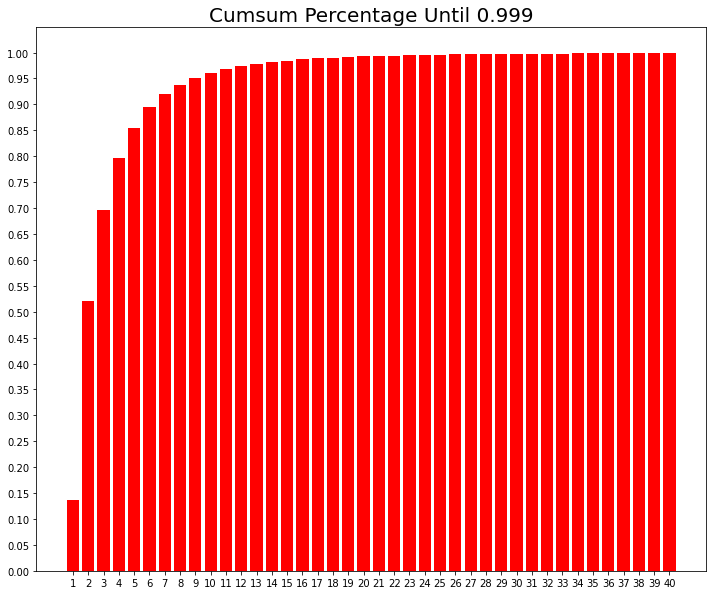

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 1-3. Session Time
* 어떤 유저가 아이폰을 구매하려고 한다. 2020년 5월에는 아이폰 se2를 구매하려는 사람이 많을 것이다.
* 그러나 그로부터 몇 달 후면 아이폰 12의 구매량이 엄청나게 증가하게 될 것이다.
* 영화나 드라마 역시 마찬가지이다. 유저들의 소비 패턴은 금방 변한다.
* 이런 이유 때문에 추천 시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요하다. 이번엔 데이터가 발생한 시간에 대해 알아보자.
<br>
<br>

추천 시스템에서 다루는 시간 관련 데이터는 다양한 측면이 있다. 데이터 생성 날짜 말고도, 접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등. 

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2014-04-01 03:00:00.124000+00:00
2014-09-30 02:59:59.430000+00:00


In [15]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838214,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


### 1-4. Data Cleansing
우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해준다. 또한 너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있다. 이 역시 제거해준다.

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207
...,...,...,...
32230485,11562157,2014-09-25 12:31:10.391000+00:00,214580372
32230486,11562157,2014-09-25 12:31:29.679000+00:00,214516012
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774


### 1-5. Train/Valid/Test split

In [19]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(Timestamp('2014-04-01 03:00:08.250000+0000', tz='UTC'),
 Timestamp('2014-09-30 02:59:23.866000+0000', tz='UTC'))

test셋과 training 셋의 기간이 겹친다. 추천 시스템은 **지금** 잘 예측하는 것이 중요하다. 1달 전에 성능이 좋은 모델을 지금 쓰면 맞지 않을 수가 있는데, 사용자들의 소비 패턴이 달라지기 때문이다. 이런 이유로 Session-Based Recommendation에서는 기간에 따라 Train, valid, test셋을 나누기도 한다.
<br>
<br>

이번 자료에서는 가장 마지막 1일 기간 동안을 Test로 2일 전부터 1일 전까지를 valid set으로 나눈다.

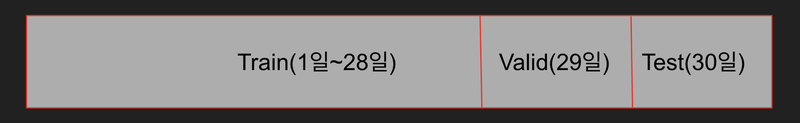

In [20]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [21]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [22]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [23]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [24]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [25]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 2. Data Pipeline
Session-Parallel Mini-Batch를 구현해본다.

### 2-1. SessionDataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

In [26]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [27]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [28]:
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100],
      dtype=int32)

In [29]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

### 2-2. SessionDataLoader

In [30]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [32]:
iter_ex = iter(tr_data_loader)

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 7]
Label Item Idx are :       [1 4 6 7]
Previous Masked Input Idx are []


## 3. Modeling

### 3-1. Evaluation Metric
모델 성능 평가를 위한 지표로 precision이나 recall이 있다. Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/구매한 n개의 아이템이 많아야 좋다. 이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용한다.
<br>
추천에서는 몇 번째로 맞추느냐도 중요하다. 구글에서 검색했을 때, 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것이다. 
<br>
따라서 순서에 민감한 지표인 MRR, NDCG같은 지표도 사용한다. 이번 자료에서는 MRR과 Recall@k를 사용한다. MRR은 정답 아이템이 나온 순번의 역수 값이다. 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고, 뒤쪽에 나오거나 안나온다면 지표가 낮아일 것이다.

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 3-2. Model Architecture

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [36]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [37]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [38]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20153)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3030750   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20153)             1027803   
Total params: 4,058,553
Trainable params: 4,058,553
Non-trainable params: 0
_________________________________________________________________


### 3-3. Model Training

In [39]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [40]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
# train_model(model, args)

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

### 3-4. Inference

In [41]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  81%|████████▏ | 22/27 [02:27<00:33,  6.70s/it]

	 - Recall@20: 0.711270
	 - MRR@20: 0.309212



## 4. 프로젝트 - Movielens 영화 SBR

* 루브릭
    * 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이 분석, 시간 분석)을 합리적으로 수행한 과정이 기술되었다.
    * 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
    * 3가지 이상의 변화를 시도하고, 그 실험 결과를 체계적으로 분석하였다.

In [27]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [28]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


실습 데이터와 다른 점
* SessionId 대신 UserId 항목이 들어갔다. 이 데이터셋은 명확한 1회 세션의 SessionId를 포함하지 않고 있어 UserId가 SessionId 역할을 해야 한다.
* Rating 정보가 포함되어 있다. 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있지만 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 한다.
* Time 항목에는 UTC Time이 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있다.

### step1. 데이터 전처리

In [29]:
import datetime
for i in range(1000209):
    data['Time'][i] = datetime.datetime.fromtimestamp(int(data['Time'][i]))

In [30]:
data['Time']

0          2000-12-31 22:12:40
1          2000-12-31 22:35:09
2          2000-12-31 22:32:48
3          2000-12-31 22:04:35
4          2001-01-06 23:38:11
                  ...         
1000204    2000-04-26 02:35:41
1000205    2000-04-25 23:21:27
1000206    2000-04-25 23:19:06
1000207    2000-04-26 02:20:48
1000208    2000-04-26 02:19:29
Name: Time, Length: 1000209, dtype: object

In [31]:
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [32]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [33]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [34]:
session_length.min(), session_length.max()

(20, 2314)

In [35]:
session_length.quantile(0.999)

1343.181000000005

In [36]:
long_session = session_length[session_length==200].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
406366,2438,908,3,2000-11-14 17:28:41
406379,2438,2294,3,2000-11-14 17:28:41
406412,2438,3812,5,2000-11-14 17:28:41
406418,2438,3835,2,2000-11-14 17:28:41
406427,2438,1186,4,2000-11-14 17:28:41
...,...,...,...,...
406356,2438,3948,4,2001-01-18 04:27:56
406461,2438,2502,4,2001-02-04 04:46:41
406372,2438,1466,4,2001-02-04 21:43:09
406413,2438,1131,5,2001-04-13 02:08:11


In [37]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

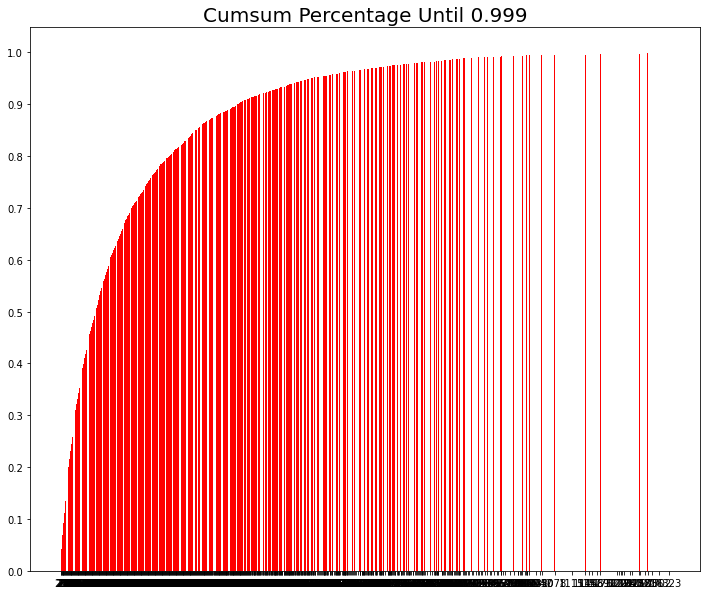

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [39]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [40]:
type(latest)

datetime.datetime

In [41]:
import datetime as dt

month_ago = latest - dt.timedelta(900)     

data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [42]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [43]:
data = cleanse_recursive(data, shortest=100, least_click=50)
data

,UserId,ItemId,Rating,Time
130,2,1198,4,2000-12-31 21:28:44
64,2,1210,4,2000-12-31 21:29:11
71,2,1217,3,2000-12-31 21:29:11
134,2,2717,3,2000-12-31 21:29:56
88,2,1293,5,2000-12-31 21:31:01
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [44]:
# Train / Valid / Test split
test_path = data_path / 'ratings.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(956703932, 1046454590)

In [45]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    UserId_last_time = data.groupby('UserId')['Time'].max()
    UserId_in_train = UserId_last_time[UserId_last_time < final_time - dt.timedelta(n_days)].index
    UserId_in_test = UserId_last_time[UserId_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(UserId_in_train)]
    after_date = data[data['UserId'].isin(UserId_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [46]:
tr, test = split_by_date(data, n_days=350)
tr, val = split_by_date(tr, n_days=350)

In [47]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [48]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 533331
	 Sessions: 2136
	 Items: 2423
	 First Time : 2000-04-25 23:25:58
	 Last Time : 2001-03-27 20:17:51

* valid Set Stats Info
	 Events: 109633
	 Sessions: 332
	 Items: 2423
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-15 13:18:32

* test Set Stats Info
	 Events: 174590
	 Sessions: 419
	 Items: 2423
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



In [49]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [50]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [51]:
# UserDataset
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [52]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2000-12-31 21:28:44,0
64,2,1210,4,2000-12-31 21:29:11,1
71,2,1217,3,2000-12-31 21:29:11,2
134,2,2717,3,2000-12-31 21:29:56,3
88,2,1293,5,2000-12-31 21:31:01,4
170,2,2943,4,2000-12-31 21:32:52,5
106,2,1225,5,2000-12-31 21:33:11,6
120,2,1193,5,2000-12-31 21:33:33,7
172,2,318,5,2000-12-31 21:33:33,8
70,2,3030,4,2000-12-31 21:33:54,9


In [53]:
tr_dataset.click_offsets

array([     0,    128,    315, ..., 533009, 533209, 533331], dtype=int32)

In [54]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2133, 2134, 2135])

In [55]:
# SessionDataLoader
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=64):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters]+1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [56]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=64)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2000-12-31 21:28:44,0
64,2,1210,4,2000-12-31 21:29:11,1
71,2,1217,3,2000-12-31 21:29:11,2
134,2,2717,3,2000-12-31 21:29:56,3
88,2,1293,5,2000-12-31 21:31:01,4
170,2,2943,4,2000-12-31 21:32:52,5
106,2,1225,5,2000-12-31 21:33:11,6
120,2,1193,5,2000-12-31 21:33:33,7
172,2,318,5,2000-12-31 21:33:33,8
70,2,3030,4,2000-12-31 21:33:54,9


In [57]:
iter_ex = iter(tr_data_loader)

In [58]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [   0    3    1  379  416    0  638  771  835   44   14    7 1177 1199
  717 1327   68    7  993  638  116   44 1614  182   28 1802  149  569
  116  354  428  910 1645 1174  570  167 1608  182    7    7  966   60
  717   31  253 1499    0   42   87    7   28  561 1714   14  253  443
 1047  443  842 1151  253  820 1425 1308]
Label Item Idx are :       [   1  128  295  380  425  492  444    0    7  908 1006 1163 1178 1179
  311 1328 1347   85   31 1399 1559 1093  383  992  667  116  581  598
 1842 1537  381  253  230 1491 1814   77  253 1977  600   14   22  444
 1063  128  638   44 1962  311  569  381 1120 1150    1   31  638   26
   28 1448   39  383  374   28  999   22]
Previous Masked Input Idx are []


In [59]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [60]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [61]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [62]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [63]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=100)

In [64]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 2423)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      371250    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 2423)                123573    
Total params: 494,823
Trainable params: 494,823
Non-trainable params: 0
_________________________________________________________________


In [65]:
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size) # args.batch_size , input_ohe
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [66]:
# # 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  85%|████████▍ | 1444/1707 [22:59<04:11,  1.05it/s]


	 - Recall@100 epoch 1: 0.481464
	 - MRR@100    epoch 1: 0.055575



Evaluation:  85%|████████▍ | 1444/1707 [20:46<03:47,  1.16it/s]


	 - Recall@100 epoch 2: 0.570908
	 - MRR@100    epoch 2: 0.079392



Evaluation:  85%|████████▍ | 1444/1707 [20:21<03:42,  1.18it/s]


	 - Recall@100 epoch 3: 0.596910
	 - MRR@100    epoch 3: 0.089675



Evaluation:  85%|████████▍ | 1444/1707 [20:06<03:39,  1.20it/s]


	 - Recall@100 epoch 4: 0.607914
	 - MRR@100    epoch 4: 0.095156



Evaluation:  85%|████████▍ | 1444/1707 [19:58<03:38,  1.20it/s]


	 - Recall@100 epoch 5: 0.611658
	 - MRR@100    epoch 5: 0.098036



Evaluation:  85%|████████▍ | 1444/1707 [19:46<03:36,  1.22it/s]


	 - Recall@100 epoch 6: 0.612545
	 - MRR@100    epoch 6: 0.099795



Evaluation:  85%|████████▍ | 1444/1707 [19:51<03:37,  1.21it/s]


	 - Recall@100 epoch 7: 0.612556
	 - MRR@100    epoch 7: 0.100772



Evaluation:  85%|████████▍ | 1444/1707 [19:56<03:37,  1.21it/s]


	 - Recall@100 epoch 8: 0.612178
	 - MRR@100    epoch 8: 0.101460



Evaluation:  85%|████████▍ | 1444/1707 [19:54<03:37,  1.21it/s]


	 - Recall@100 epoch 9: 0.611474
	 - MRR@100    epoch 9: 0.101889



Evaluation:  85%|████████▍ | 1444/1707 [19:39<03:34,  1.22it/s]


	 - Recall@100 epoch 10: 0.609829
	 - MRR@100    epoch 10: 0.101876



* 회고
    * 세션 기반 추천에 대한 개념을 알게 됐지만, 데이터 전처리 과정에서 데이터셋마다 차이가 있고, 각각 다른 방식으로 전처리를 해주고 다듬는 과정에 어려움을 느꼈다. 모델 자체를 설계하는 부분에서도 어려웠지만 특히 전처리가 더 어렵다고 느낀 노드였음.